In [60]:
import os, glob, inspect
import copy
import numpy as np
import pandas as pd
# pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 200)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import rankdata
from scipy import stats
from datetime import datetime, timedelta
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import mixture
from math import pi
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from kneed import DataGenerator, KneeLocator
from sklearn.feature_selection import f_regression
import pprint
import sklearn
from sklearn import tree
from sklearn.tree import export_text
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, _tree
import uuid
from importlib.machinery import SourceFileLoader

cwd = os.getcwd()
today = datetime.today().strftime('%Y-%m-%d')
colors = ['r','g','b','c','m','y','k']

print(cwd)
print(today)

/home/cst/SmartTradzt/PriceSegmentation
2021-07-27


# Functions and Constanta

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def export_py_code(tree, feature_names, max_depth=100, spacing=4):
    if spacing < 2:
        raise ValueError('spacing must be > 1')

    # Clean up feature names (for correctness)
    nums = string.digits
    alnums = string.ascii_letters + nums
    clean = lambda s: ''.join(c if c in alnums else '_' for c in s)
    features = [clean(x) for x in feature_names]
    features = ['_'+x if x[0] in nums else x for x in features if x]
    if len(set(features)) != len(feature_names):
        raise ValueError('invalid feature names')

    # First: export tree to text
    res = export_text(tree, feature_names=features, 
                        max_depth=max_depth,
                        decimals=6,
                        spacing=spacing-1)

    # Second: generate Python code from the text
    skip, dash = ' '*spacing, '-'*(spacing-1)
    code = 'def decision_tree({}):\n'.format(', '.join(features))
    for line in repr(tree).split('\n'):
        code += skip + "# " + line + '\n'
    for line in res.split('\n'):
        line = line.rstrip().replace('|',' ')
        if '<' in line or '>' in line:
            line, val = line.rsplit(maxsplit=1)
            line = line.replace(' ' + dash, 'if')
            line = '{} {:g}:'.format(line, float(val))
        else:
            line = line.replace(' {} class:'.format(dash), 'return')
        code += skip + line + '\n'

    return code.replace('- value:','return').replace('-','')

def get_func_args(f):
    if hasattr(f, 'args'):
        return f.args
    else:
        return list(inspect.signature(f).parameters)

def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(threshold))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(threshold))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("return " + str(label[0][0]))
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df = pd.DataFrame(rules).dropna(how='all')
    df['Return'] = pd.Series(vals)
    return df


def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(threshold))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(threshold))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("return " + str(label[0][0]))
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df = pd.DataFrame(rules).dropna(how='all')
    df['Return'] = pd.Series(vals)
    return df

In [88]:
# Set minimum accepted cluster

# min_cluster = 3
# min_component = 2 # for PCA
categorical_features = []
numerical_features = []
target = 'Price Premium'

# tree setting
max_depth=3
min_samples_split=100
ccp_alpha=0.001

In [4]:
filename = 'Polymer Spot Sales Contract v2.xlsx'
filepath = os.path.join(cwd,'InternalData',filename)
print(filepath)

/home/cst/SmartTradzt/PriceSegmentation/InternalData/Polymer Spot Sales Contract v2.xlsx


In [5]:
data = pd.read_excel(filepath,sheet_name='Polymer Spot Sales Contract')

In [6]:
data.shape

(1817, 33)

In [7]:
# data['Price Premium Pctg'] = data['Price Premium']/data['REFERENCE_MARKET_PRICE']

In [8]:
# Fill in empty data
data['Customer Industry'].fillna('No Customer Industry',inplace=True)
data['Customer Type'].fillna('No Customer Type',inplace=True)
data['Cross Boarder'].fillna('No Cross Boarder',inplace=True)

In [9]:
data.head()

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer Type,Customer Industry,Grade,Material,Payment Term,Incoterm,Country,Destination Port,City State,Shipping Condition,Export/Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,End Customer,Mfg-Petroleum Prod,HD5301AA,72000544,ZB30,DAP,Malaysia,MYSG00 KLANG VALLEY,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,TT60SBLC,CFR,Bangladesh,BDCGP CHITTAGONG,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,Distributor / Trader,Mfg-Petroleum Prod,HD5201AA,72000539,ZM60,DAP,Malaysia,MYPG04 PRAI,MYPG04 PRAI,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,Distributor / Trader,Mfg-Petroleum Prod,C150Y,72000448,LC60,CFR,Hong Kong,HKHKG HONG KONG PORT,NaN,MARINE PACK,EXPORT,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,End Customer,Mfg-Petroleum Prod,LL0209SA,72000608,ZB60,DAP,Malaysia,MYKD01 ALOR SETAR,MYSG00 KLANG VALLEY,TRUCK PACK(Drum),DOMESTIC,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372


<AxesSubplot:>

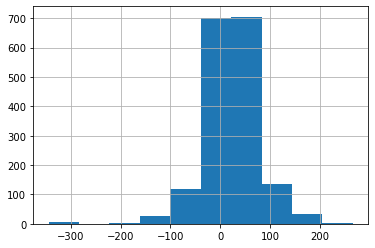

In [10]:
data[data['Currency']=='USD']['Price Premium'].hist()

<AxesSubplot:>

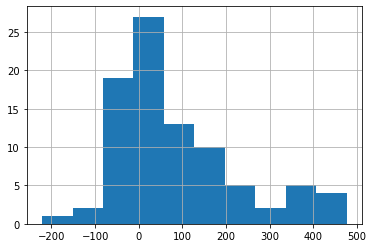

In [11]:
data[data['Currency']!='USD']['Price Premium'].hist()

<b>Remove outliers.</b>

In [12]:
data = data[
            (
                (data['Price Premium']>=(data['Price Premium'].mean() - (3*data['Price Premium'].std())))
                & (data['Price Premium']<=(data['Price Premium'].mean() + (3*data['Price Premium'].std())))
            )
            ]
data.shape

(1793, 33)

# Feature Assessment

In [13]:
features = ['Customer Type', 'Customer Industry', 'Grade', 
       'Country', 'Destination Port', 'City State',
       'Shipping Condition', 'Export/Domestic', 'QUANTITY']

In [15]:
for col,type_ in zip(data[features].columns,data[features].dtypes):
    
    if str(type_)=='object' and col!=target:        
        categorical_features.append(col)        
    else:
        numerical_features.append(col)


In [16]:
categorical_features, numerical_features

(['Customer Type',
  'Customer Industry',
  'Grade',
  'Country',
  'Destination Port',
  'City State',
  'Shipping Condition',
  'Export/Domestic'],
 ['QUANTITY'])

## Feature Enginering

<b>Replace all categorical values with values relative to the target variable.</b>

In [17]:
for categorical_feature in categorical_features:
    
    data[categorical_feature] = data.groupby('Customer Type')[target].transform('max')
    

## Linear Model

<b>This will be a function. Input are: dataframe, target varible, and features.</b>

In [28]:
# lin_reg = LinearRegression()
# lin_reg.fit(data[all_possible_features].values,data[target].values.reshape(-1, 1))
# print(lin_reg.intercept_,lin_reg.coef_)
# lin_reg = sm.add_constant(np.array(X_train))

lin_reg = sm.OLS(np.array(data[target].values.reshape(-1, 1),dtype=float),np.array(data[features].values,dtype=float)).fit()
print(lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.254
Model:                            OLS   Adj. R-squared (uncentered):              0.253
Method:                 Least Squares   F-statistic:                              203.6
Date:                Tue, 27 Jul 2021   Prob (F-statistic):                   1.26e-113
Time:                        08:11:19   Log-Likelihood:                         -9520.2
No. Observations:                1793   AIC:                                  1.905e+04
Df Residuals:                    1790   BIC:                                  1.906e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
freg = f_regression(
                    np.array(data[features].values,dtype=float)
                    , np.array(data[target].values.reshape(-1, 1),dtype=float)
                    )
p_values = freg[1]
p_values

/home/cst/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([2.64866766e-40, 2.64866766e-40, 2.64866766e-40, 2.64866766e-40,
       2.64866766e-40, 2.64866766e-40, 2.64866766e-40, 2.64866766e-40,
       8.70101332e-23])

In [30]:
feature_pval = dict()

for p_value, feature in zip(p_values,features):
    
    feature_pval[feature] = round(p_value, 3)    

In [31]:
feature_pval

{'Customer Type': 0.0,
 'Customer Industry': 0.0,
 'Grade': 0.0,
 'Country': 0.0,
 'Destination Port': 0.0,
 'City State': 0.0,
 'Shipping Condition': 0.0,
 'Export/Domestic': 0.0,
 'QUANTITY': 0.0}

<b>Above will a return to this specific function.</b>

# Segmentation

<b>There are many to do this but this exercise uses Decision Tree. The initial was to do multiple segmentation: customers segmentation along with transaction segmentation and then pair these segmentations but then the result was not too good as there limited features on customers segmentation that can be used.</b>

<b>This will be a specific function. Input are:
- Dataframe
- Features
- Target feature

Return values, choose one of below: (can be discussed later)
- Dataframe with labeled cluster    
- JSON with customer code and cluster (could return duplicate values if there are more than 1 customer code for different transaction)
</b>


In [33]:
clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42, ccp_alpha=ccp_alpha)
clf.fit(data[features],data[target])

DecisionTreeRegressor(ccp_alpha=0.001, max_depth=3, min_samples_split=100,
                      random_state=42)

In [37]:
text_representation = tree.export_text(clf, feature_names=features)
print(text_representation)

|--- Customer Type <= 197.07
|   |--- QUANTITY <= 236.00
|   |   |--- QUANTITY <= 155.00
|   |   |   |--- value: [18.90]
|   |   |--- QUANTITY >  155.00
|   |   |   |--- value: [13.52]
|   |--- QUANTITY >  236.00
|   |   |--- QUANTITY <= 465.00
|   |   |   |--- value: [3.00]
|   |   |--- QUANTITY >  465.00
|   |   |   |--- value: [-9.30]
|--- Customer Type >  197.07
|   |--- QUANTITY <= 25.38
|   |   |--- QUANTITY <= 15.12
|   |   |   |--- value: [98.15]
|   |   |--- QUANTITY >  15.12
|   |   |   |--- value: [54.33]
|   |--- QUANTITY >  25.38
|   |   |--- QUANTITY <= 310.00
|   |   |   |--- value: [41.17]
|   |   |--- QUANTITY >  310.00
|   |   |   |--- value: [21.40]



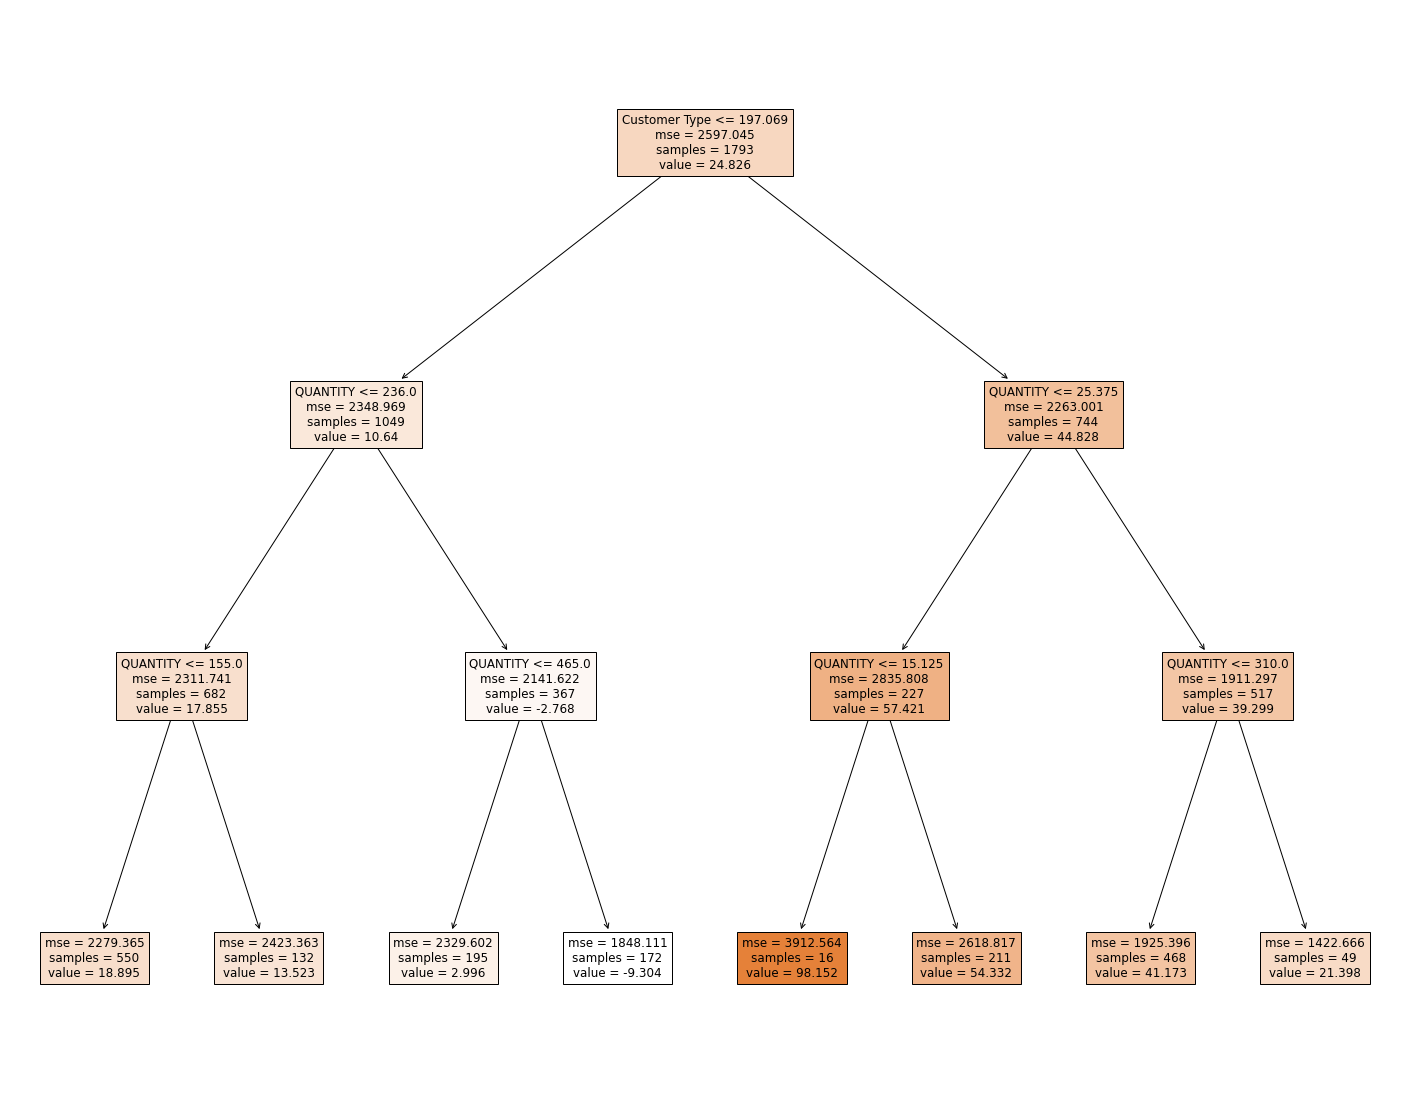

In [38]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, feature_names=features,filled=True)

In [41]:
rules = get_rules(clf, features, None)
rules_dict = {}
for i,r in enumerate(rules):   
    rules_dict[i] = r

pprint.pprint(rules_dict)

{0: 'if (Customer Type <= 197.069) and (QUANTITY <= 236.0) and (QUANTITY <= '
    '155.0) then response: 18.895 | based on 550 samples',
 1: 'if (Customer Type > 197.069) and (QUANTITY > 25.375) and (QUANTITY <= '
    '310.0) then response: 41.173 | based on 468 samples',
 2: 'if (Customer Type > 197.069) and (QUANTITY <= 25.375) and (QUANTITY > '
    '15.125) then response: 54.332 | based on 211 samples',
 3: 'if (Customer Type <= 197.069) and (QUANTITY > 236.0) and (QUANTITY <= '
    '465.0) then response: 2.996 | based on 195 samples',
 4: 'if (Customer Type <= 197.069) and (QUANTITY > 236.0) and (QUANTITY > '
    '465.0) then response: -9.304 | based on 172 samples',
 5: 'if (Customer Type <= 197.069) and (QUANTITY <= 236.0) and (QUANTITY > '
    '155.0) then response: 13.523 | based on 132 samples',
 6: 'if (Customer Type > 197.069) and (QUANTITY > 25.375) and (QUANTITY > '
    '310.0) then response: 21.398 | based on 49 samples',
 7: 'if (Customer Type > 197.069) and (QUANTITY <=

In [42]:
rules_df = tree_to_df(clf, features)
rules_df

,0,1,2,Return
0,Customer Type <= 197.06922912597656,QUANTITY <= 236.0,QUANTITY <= 155.0,return 18.895034218181816
1,QUANTITY > 155.0,None,None,return 13.522700227272718
2,QUANTITY > 236.0,QUANTITY <= 465.0,None,return 2.99643210256411
3,QUANTITY > 465.0,None,None,return -9.304236279069762
4,Customer Type > 197.06922912597656,QUANTITY <= 25.375,QUANTITY <= 15.125,return 98.15170812500006
5,QUANTITY > 15.125,None,None,return 54.33214393364933
6,QUANTITY > 25.375,QUANTITY <= 310.0,None,return 41.172770128205144
7,QUANTITY > 310.0,None,None,return 21.398338571428557


In [43]:
res = export_py_code(clf, feature_names=features, spacing=4)
print(res)

def decision_tree(Customer_Type, Customer_Industry, Grade, Country, Destination_Port, City_State, Shipping_Condition, Export_Domestic, QUANTITY):
    # DecisionTreeRegressor(ccp_alpha=0.001, max_depth=3, min_samples_split=100,
    #                       random_state=42)
    if Customer_Type <= 197.069:
        if QUANTITY <= 236:
            if QUANTITY <= 155:
                 return [18.895034]
            if QUANTITY > 155:
                 return [13.522700]
        if QUANTITY > 236:
            if QUANTITY <= 465:
                 return [2.996432]
            if QUANTITY > 465:
                 return [9.304236]
    if Customer_Type > 197.069:
        if QUANTITY <= 25.375:
            if QUANTITY <= 15.125:
                 return [98.151708]
            if QUANTITY > 15.125:
                 return [54.332144]
        if QUANTITY > 25.375:
            if QUANTITY <= 310:
                 return [41.172770]
            if QUANTITY > 310:
                 return [21.398339]
   

In [53]:
filename = str(uuid.uuid4())
filename = '_'+filename+'.py'
filename

'_96512323-bbf9-4409-a4d5-e4bb8f66fdee.py'

In [54]:
# save the string as a function using above filename
with open(filename, 'w') as f:
    f.write(res)    

In [69]:
import importlib.util
spec = importlib.util.spec_from_file_location("module.name", filename)
f = importlib.util.module_from_spec(spec)
spec.loader.exec_module(f)
f.decision_tree

<function module.name.decision_tree(Customer_Type, Customer_Industry, Grade, Country, Destination_Port, City_State, Shipping_Condition, Export_Domestic, QUANTITY)>

In [80]:
f.decision_tree(Customer_Type=212.72594,Customer_Industry=212.72594,Grade=212.72594,Country=212.72594,Destination_Port=212.72594,
               City_State=212.72594, Shipping_Condition=212.72594, Export_Domestic=212.72594, QUANTITY=22.0)

[54.332144]

In [79]:
data

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer_Type,Customer_Industry,Grade,Material,Payment Term,Incoterm,Country,Destination_Port,City_State,Shipping_Condition,Export_Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,212.72594,212.72594,212.72594,72000544,ZB30,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,181.41252,181.41252,181.41252,72000448,TT60SBLC,CFR,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,181.41252,181.41252,181.41252,72000539,ZM60,DAP,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,181.41252,181.41252,181.41252,72000448,LC60,CFR,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,212.72594,212.72594,212.72594,72000608,ZB60,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,2020-02-20,QTN-0000029888-1,1,30027440,QUOTATION,PT. BERLINA TBK,8010001242,212.72594,212.72594,212.72594,72000448,LC60,CFR,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M169,2020-03-31,2020-03-24,4.06,17.5,MT,USD,910.0,1006.51320,951.00,55.51320,950.0,1.229771,1009.999771
1813,2020-03-26,QTN-0000030542-1,1,30028105,QUOTATION,TYCOPLAS SDN. BHD.,8010001493,212.72594,212.72594,212.72594,72000608,ZM60,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2020-03-31,2020-03-24,4.20,22.5,MT,USD,860.0,850.84511,872.50,-21.65489,880.0,22.278356,874.998356
1814,2020-04-08,QTN-0000030826-1,1,30028345,QUOTATION,"PREMIUM PLAST CO., LTD",8010001205,181.41252,181.41252,181.41252,72000448,TT30,DDP,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M169,2020-04-30,2020-04-23,32.48,402.5,MT,USD,746.0,925.20085,945.00,-19.79915,786.0,5.000000,926.000000
1815,2020-04-08,QTN-0000030829-1,1,30028350,QUOTATION,"INTERCORDIA CO., LTD",8010000926,181.41252,181.41252,181.41252,72000448,TT45SBLC,DDP,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M169,2020-04-30,2020-04-23,32.48,262.5,MT,USD,746.0,952.93955,945.00,7.93955,786.0,5.000000,955.000000


In [70]:
get_func_args(f.decision_tree)

['Customer_Type',
 'Customer_Industry',
 'Grade',
 'Country',
 'Destination_Port',
 'City_State',
 'Shipping_Condition',
 'Export_Domestic',
 'QUANTITY']

In [72]:
for a,b in zip(features,get_func_args(f.decision_tree)): 
    print(a,b)
    data.rename(columns={a:b},inplace=True)

Customer Type Customer_Type
Customer Industry Customer_Industry
Grade Grade
Country Country
Destination Port Destination_Port
City State City_State
Shipping Condition Shipping_Condition
Export/Domestic Export_Domestic
QUANTITY QUANTITY


In [81]:
text_function = 'f.'+str(f.decision_tree.__name__)+'('+','.join([item+"=x['"+item+"']" for item in get_func_args(f.decision_tree)])+')'
text_function

"f.decision_tree(Customer_Type=x['Customer_Type'],Customer_Industry=x['Customer_Industry'],Grade=x['Grade'],Country=x['Country'],Destination_Port=x['Destination_Port'],City_State=x['City_State'],Shipping_Condition=x['Shipping_Condition'],Export_Domestic=x['Export_Domestic'],QUANTITY=x['QUANTITY'])"

In [82]:
data['node'] = data.apply(lambda x: eval(text_function), axis=1) 
data['node'] = data['node'].apply(lambda x:str(x).replace('[','').replace(']',''))

le = LabelEncoder()
data['segment'] = le.fit_transform(data['node'])
data['segment'].value_counts(normalize=True)

1    0.306748
4    0.261015
5    0.117680
2    0.108756
6    0.095929
0    0.073620
3    0.027328
7    0.008924
Name: segment, dtype: float64

<b>It is better to return the complete dataframe.</b>

# Price Segmentation

## Without Power Price Index

<b>Input:
- Dataframe
- Target feature
- Cut off in the form of JSON like below
- Signal if the JSON is Power Price Index or not
</b>

In [111]:
cut_off = dict()
cut_off['floor'] = 0.1
cut_off['target'] = 0.5
cut_off['offer'] = 0.9
print(cut_off)

{'floor': 0.1, 'target': 0.5, 'offer': 0.9}


In [112]:
data

,Contract Execution Date,PMT No.,Item No,Sales Contract No.,Contract/Spot,Sold to Customer Name,Sold to Customer Code,Customer_Type,Customer_Industry,Grade,Material,Payment Term,Incoterm,Country,Destination_Port,City_State,Shipping_Condition,Export_Domestic,Cross Boarder,Plant,RETA,BL Date,EXCHANGE_RATE,QUANTITY,UOM,Currency,FLOOR_PRICE,NORMALISED_INVOICE_PRICE,REFERENCE_MARKET_PRICE,Price Premium,PRODUCTBASEPRICE,GRADEALPHA,INVOICEPRICE,node,segment
0,2017-08-04,QTN-0000012192-1,1,30010898,QUOTATION,DURA-MINE SDN BHD.,8010000770,212.72594,212.72594,212.72594,72000544,ZB30,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2017-08-08,2017-08-01,4.29,22.0,MT,USD,1070.0,1150.98423,1086.25,64.73423,1090.0,20.000000,1177.000000,54.332144,5
1,2017-11-22,QTN-0000013779-1,1,30012429,QUOTATION,CJ POLYMERS SDN. BHD.,8010000714,181.41252,181.41252,181.41252,72000448,TT60SBLC,CFR,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M059,2018-01-10,2018-01-03,4.22,306.0,MT,USD,1290.0,1235.58130,1288.75,-53.16870,1290.0,41.669931,1279.999931,2.996432,2
2,2017-09-11,QTN-0000012648-1,1,30011297,QUOTATION,SUMIKENG (M) SDN BHD,8010001403,181.41252,181.41252,181.41252,72000539,ZM60,DAP,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M167,2017-09-30,2017-09-23,4.29,22.0,MT,USD,1170.0,1230.01552,1135.00,95.01552,1160.0,53.080955,1261.000955,18.895034,1
3,2017-05-15,QTN-0000010801-1,2,30009609,QUOTATION,ZHEJIANG FUTURE PETROCHEMICAL,8010001559,181.41252,181.41252,181.41252,72000448,LC60,CFR,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M059,2017-05-31,2017-05-24,0.00,102.0,MT,USD,1190.0,1202.83563,1302.50,-99.66437,1310.0,78.407735,1207.002265,18.895034,1
4,2018-08-06,QTN-0000018707-1,1,30016459,QUOTATION,CHONG WAH PLASTICS SDN BHD,8010000709,212.72594,212.72594,212.72594,72000608,ZB60,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2018-08-31,2018-08-24,4.04,180.0,MT,USD,1190.0,1312.38099,1181.25,131.13099,1210.0,21.566372,1336.996372,41.17277,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,2020-02-20,QTN-0000029888-1,1,30027440,QUOTATION,PT. BERLINA TBK,8010001242,212.72594,212.72594,212.72594,72000448,LC60,CFR,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M169,2020-03-31,2020-03-24,4.06,17.5,MT,USD,910.0,1006.51320,951.00,55.51320,950.0,1.229771,1009.999771,54.332144,5
1813,2020-03-26,QTN-0000030542-1,1,30028105,QUOTATION,TYCOPLAS SDN. BHD.,8010001493,212.72594,212.72594,212.72594,72000608,ZM60,DAP,212.72594,212.72594,212.72594,212.72594,212.72594,NONCROSSBORDER,M167,2020-03-31,2020-03-24,4.20,22.5,MT,USD,860.0,850.84511,872.50,-21.65489,880.0,22.278356,874.998356,54.332144,5
1814,2020-04-08,QTN-0000030826-1,1,30028345,QUOTATION,"PREMIUM PLAST CO., LTD",8010001205,181.41252,181.41252,181.41252,72000448,TT30,DDP,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M169,2020-04-30,2020-04-23,32.48,402.5,MT,USD,746.0,925.20085,945.00,-19.79915,786.0,5.000000,926.000000,2.996432,2
1815,2020-04-08,QTN-0000030829-1,1,30028350,QUOTATION,"INTERCORDIA CO., LTD",8010000926,181.41252,181.41252,181.41252,72000448,TT45SBLC,DDP,181.41252,181.41252,181.41252,181.41252,181.41252,NONCROSSBORDER,M169,2020-04-30,2020-04-23,32.48,262.5,MT,USD,746.0,952.93955,945.00,7.93955,786.0,5.000000,955.000000,2.996432,2


Segment: 5
cut_off_values: {'floor': -53.88018900000017, 'target': -21.249064999999952, 'offer': -5.6018000000000026}


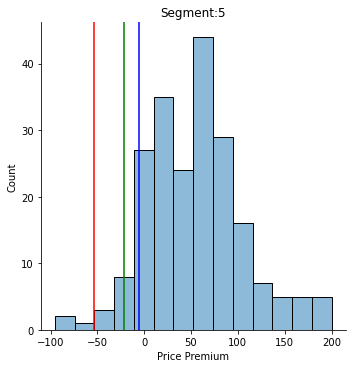

------------------------------------
Segment: 2
cut_off_values: {'floor': -119.81634700000001, 'target': -83.737435, 'offer': -67.96992340000004}


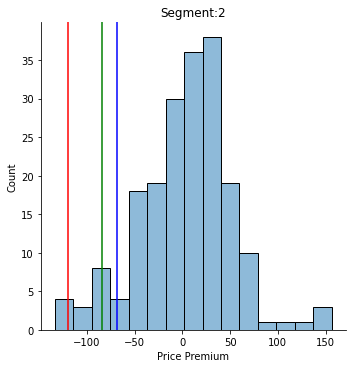

------------------------------------
Segment: 1
cut_off_values: {'floor': -107.43575849999999, 'target': -56.454184999999995, 'offer': -40.32521}


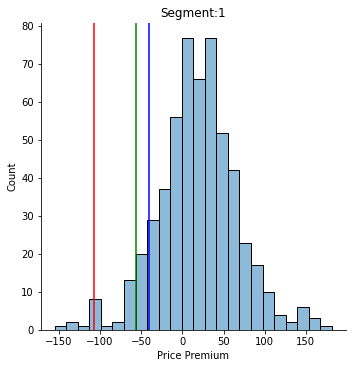

------------------------------------
Segment: 4
cut_off_values: {'floor': -43.654193299999534, 'target': -14.5000785000001, 'offer': -5.0288188000000025}


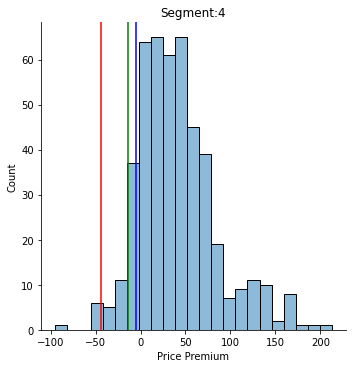

------------------------------------
Segment: 6
cut_off_values: {'floor': -121.5297139, 'target': -82.2618945, 'offer': -66.43258500000007}


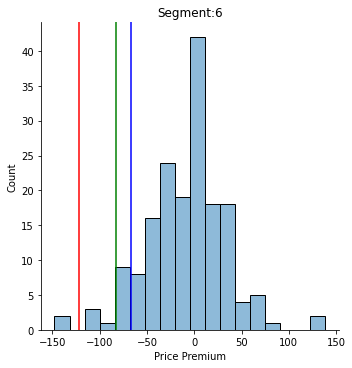

------------------------------------
Segment: 0
cut_off_values: {'floor': -101.6488829, 'target': -76.6984535, 'offer': -54.08154000000002}


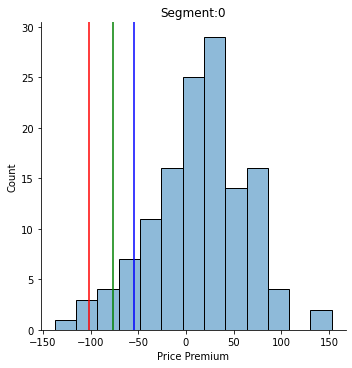

------------------------------------
Segment: 7
cut_off_values: {'floor': -20.68504, 'target': 26.574799999999996, 'offer': 48.360659999999996}


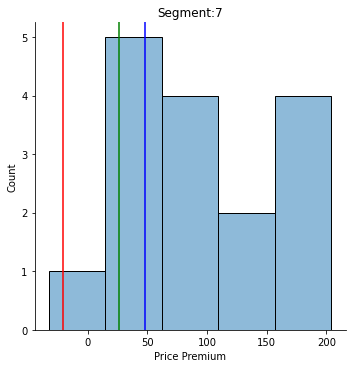

------------------------------------
Segment: 3
cut_off_values: {'floor': -50.070457999999945, 'target': -31.49908, 'offer': -29.9923328}


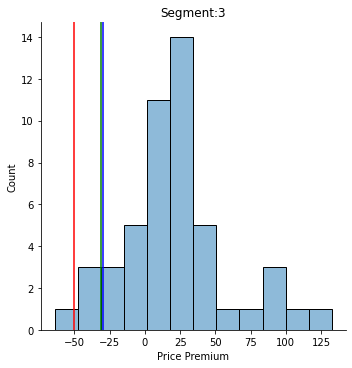

------------------------------------


In [114]:
for segment in data['segment'].unique():

    print('Segment:',segment)
    
    sub = data[data['segment']==segment]
        
    sns.displot(data=sub, x=target,alpha=0.5)
    plt.title('Segment:'+str(segment))        

    cut_off_values = dict()
    
    i = 0
    for k,v in cut_off.items():
    
        cut_off_values[k] = np.percentile(sub[target], v*10)                
        plt.axvline(np.percentile(sub[target], v*10), color=colors[i] )
        
        i=i+1
        
    print('cut_off_values:',cut_off_values)
    

    plt.show()
    
    
    print('------------------------------------')
    


## With Power Price Index

In [115]:
cut_off_price_power = dict()

segment = 0
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.01
cut_off_price_power[segment]['target'] = 0.5
cut_off_price_power[segment]['offer'] = 0.99

segment = 1
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.15
cut_off_price_power[segment]['target'] = 0.65
cut_off_price_power[segment]['offer'] = 0.95

segment = 2
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.05
cut_off_price_power[segment]['target'] = 0.55
cut_off_price_power[segment]['offer'] = 0.95

segment = 3
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.1
cut_off_price_power[segment]['target'] = 0.5
cut_off_price_power[segment]['offer'] = 0.9

segment = 4
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.05
cut_off_price_power[segment]['target'] = 0.75
cut_off_price_power[segment]['offer'] = 0.95

segment = 5
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.15
cut_off_price_power[segment]['target'] = 0.65
cut_off_price_power[segment]['offer'] = 0.85

segment = 6
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.25
cut_off_price_power[segment]['target'] = 0.45
cut_off_price_power[segment]['offer'] = 0.95

segment = 7
cut_off_price_power[segment] = dict()
cut_off_price_power[segment]['floor'] = 0.01
cut_off_price_power[segment]['target'] = 0.5
cut_off_price_power[segment]['offer'] = 0.95

pprint.pprint(cut_off_price_power)

{0: {'floor': 0.01, 'offer': 0.99, 'target': 0.5},
 1: {'floor': 0.15, 'offer': 0.95, 'target': 0.65},
 2: {'floor': 0.05, 'offer': 0.95, 'target': 0.55},
 3: {'floor': 0.1, 'offer': 0.9, 'target': 0.5},
 4: {'floor': 0.05, 'offer': 0.95, 'target': 0.75},
 5: {'floor': 0.15, 'offer': 0.85, 'target': 0.65},
 6: {'floor': 0.25, 'offer': 0.95, 'target': 0.45},
 7: {'floor': 0.01, 'offer': 0.95, 'target': 0.5}}


Segment: 5
(211, 35)
cut_off_values: {'floor': -42.106069500000004, 'target': -10.216194500000054, 'offer': -5.815997000000024}


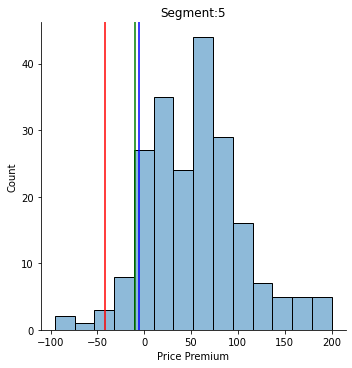

----------------------------------
Segment: 2
(195, 35)
cut_off_values: {'floor': -121.8027236, 'target': -83.66323, 'offer': -61.04152229999984}


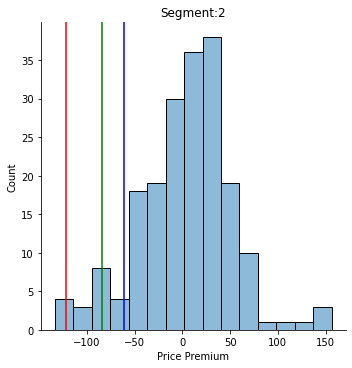

----------------------------------
Segment: 1
(550, 35)
cut_off_values: {'floor': -103.13390370000002, 'target': -51.0, 'offer': -40.08565765000009}


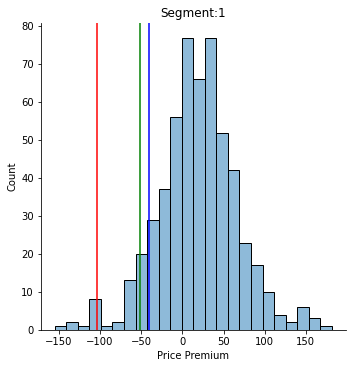

----------------------------------
Segment: 4
(468, 35)
cut_off_values: {'floor': -52.52316924999987, 'target': -7.707636000000068, 'offer': -5.028776350000027}


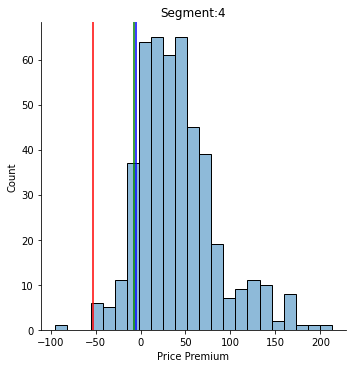

----------------------------------
Segment: 6
(172, 35)
cut_off_values: {'floor': -101.07243025, 'target': -83.8049298, 'offer': -64.50999999999999}


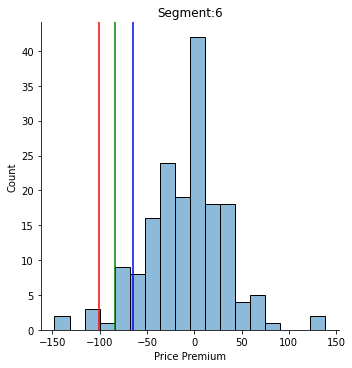

----------------------------------
Segment: 0
(132, 35)
cut_off_values: {'floor': -132.93026219, 'target': -76.6984535, 'offer': -51.09528036}


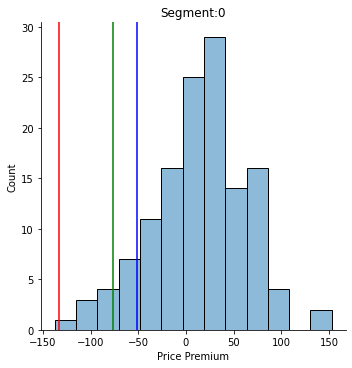

----------------------------------
Segment: 7
(16, 35)
cut_off_values: {'floor': -31.318504000000004, 'target': 26.574799999999996, 'offer': 48.80942999999999}


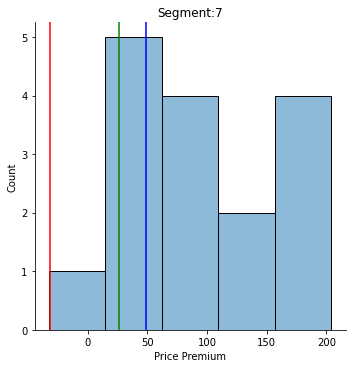

----------------------------------
Segment: 3
(49, 35)
cut_off_values: {'floor': -50.070457999999945, 'target': -31.49908, 'offer': -29.9923328}


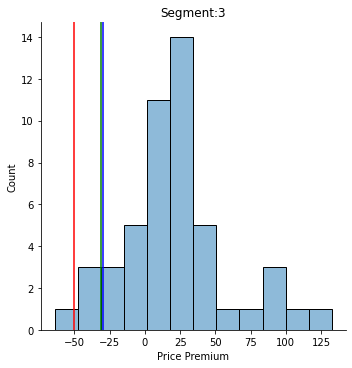

----------------------------------


In [116]:
for segment in data['segment'].unique():
    
    print('Segment:',segment)
    
    sub = data[data['segment']==segment]
      
    print(sub.shape)
    
#     sub[target].hist()
        
    sns.displot(data=sub, x=target, alpha=0.5)
    plt.title('Segment:'+str(segment))        

    cut_off_values = dict()
    
    i = 0
    for k,v in cut_off_price_power[segment].items():
    
        cut_off_values[k] = np.percentile(sub[target], v*10)                
        plt.axvline(np.percentile(sub[target], v*10), color=colors[i] )
        
        i=i+1
        
    print('cut_off_values:',cut_off_values)
    

    plt.show()
    
    print('----------------------------------')

